# How to sample from a custom probability distribution

## SciPy source code, numerical routines and inverse transform sampling

Never in my life would I have thought this is what I would have spent my Wednesday morning looking at, but as with most issues there is always a motivating problem. Here was mine. [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is defined by the following equation:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

In simple terms, the change in the value of our process, `S`, over some time increment `dt` is comprised of two parts:
 - some constant deterministic drift term
 - some stochastic term

Importantly, GBM is characrterised by that stochastic element being normally distributed - the `dW` element is called a [Wiener Process](https://en.wikipedia.org/wiki/Wiener_process) or more commonly a 'random walk'. My problem was the following - I want to simulate a load of these 'stochastic paths' but I don't want to sample my stochastic change from a normal distribution.

Instead, I want to cretae my own 'custom' distribution - in particular I wanted a variance preserving transform (i.e. the variance was still `1` like the standard normal) but that had juicy fat tails (excess kurtosis). __How can I do this within the efficient SciPy/NumPy framework? More generally, what's going on under the hood when I request random samples from either NumPy's random module or SciPy?__

## What's so hard about sampling?

This was my first thought - mostly because I'd never actually given it much thought. To my mind as long as I could draw (or write down) my distribution then sampling should be a fairly easy extension, mostly because of my fairly sloppy use of the term 'distribution'. In other words, I thought as long as i could draw the pdf then I could easily sample from it.

To keep this practical and include nice graphs let's continue with my motivating example. My trick to fatten the tails whilst keeping the variance fixed is to utilise Jensen's inequality. It turns out that we can 'stochastise' our variance and through that generate a fatter tailed distribution. Our pdf will thus be:
 - `0.5` * n(0, sigma * sqrt(1 + a))
 - `0.5` * n(0, sigma * sqrt(1 - a))

so we take the average of two normal pdfs where we skew the variance slightly lower for one and slightly higher for the other. If you bash through the proof of the variance you'll come out with the neat result that this distribution will have a variance of `sigma`.

What does this look like? The following code plots the pdfs of a variety of these distributions for various values of `a`. In the interest of keeping everything clear I've written my own version of the standard normal pdf but you could easily use the built in NumpPy or SciPy versions.

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

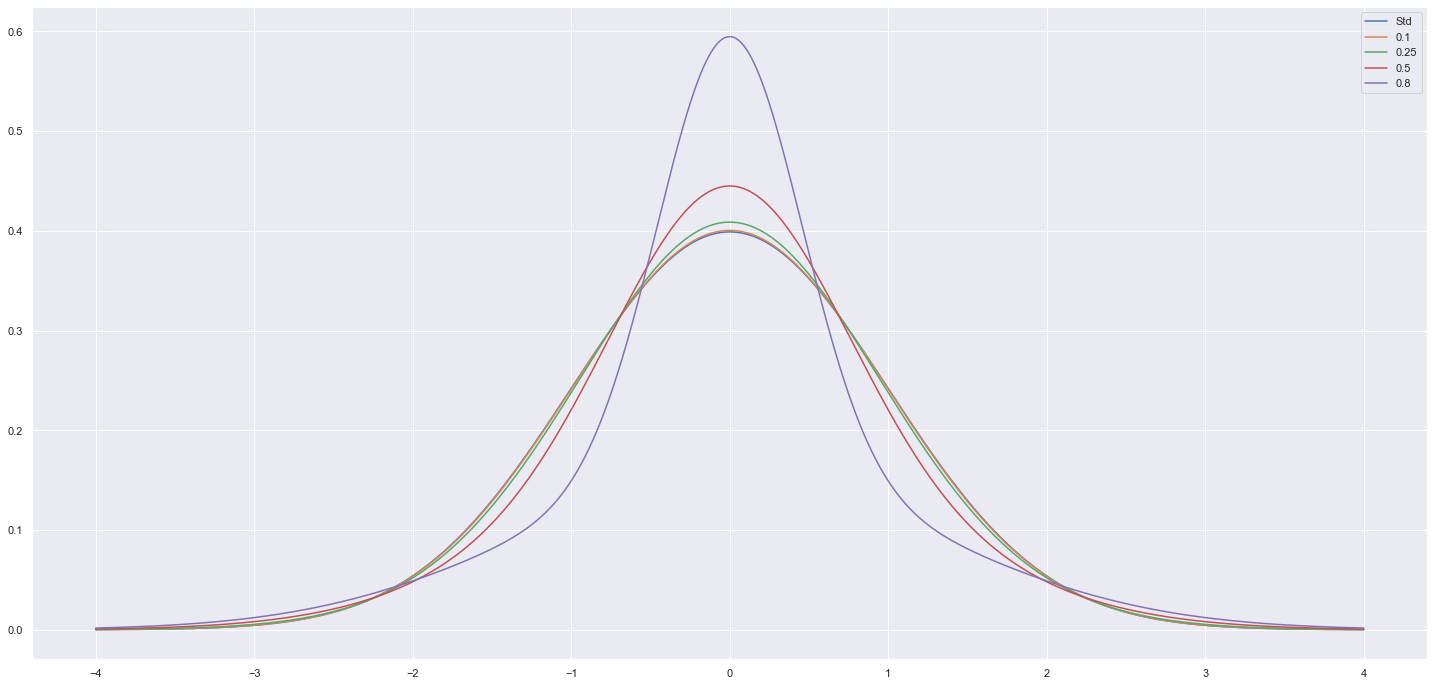

In [2]:
# this is the 1d domain over which our pdf exists
xs = np.linspace(-4.0, 4.0, 10000)

# define normal pdf
def norm_p(x, mu=0, sigma=1):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-0.5 * ((x - mu)**2 / sigma**2))

# define our pdf
def p(x, mu=0, sigma=1, sigma_dev=0):
    low = norm_p(x, mu, sigma * (1 - sigma_dev)**0.5)
    high = norm_p(x, mu, sigma * (1 + sigma_dev)**0.5)
    return 0.5 * (low + high)

# define our params
mu = 0
sigma = 1
devs = [0.1, 0.25, 0.5, 0.8]
pdfs = {'Std': [norm_p(x) for x in xs]}

# define them
for d in devs:
    pdf = [p(x, sigma_dev=d) for x in xs]
    pdfs[d] = pdf

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
for label, pdf in pdfs.items():
    ax.plot(xs, pdf, label=label)

ax.legend();

So as we progressively average distributions with larger deviations around a constant variance of `1` we get:
 - a taller peak of the distribution
 - narrower shoulders
 - fatter tails

We also get these nice constant crossover points which we can use to formally define what it really means to talk about body/shoudler and tails of distributions. The tails are those areas just past 2 sigma where the tail probabilities increase as we stochasticise the variance. In other words it's the part of the distribution that is convex to stochastic variance - makes sense when we think about kurtosis as the variance of variance - more stochastic variance, more kurtosis, more probability in the tails.

## Let's get back to sampling

My naive thought was the following - as long as I could generate the above graph then sampling should be a simple extension. This couldn't be further from the truth.In reality there is a whole field dedicated to sampling and a load of very smart people tweaking and improving algorithms to get us the performance we have now when we wish to grab `1,000,000` numbers from a standard normal.

When we talk about sampling from the normal distribution in particular we've gone from [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) (with polynomial approximations for the inverse CDF) to the very clever [Box-Muller](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) method to [Marsaglia Polar](https://en.wikipedia.org/wiki/Marsaglia_polar_method) and now on to the [Ziggurat algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm) which is actually what NumPy implements currently.

## Let's focus on inverse transform sampling

The above array of processes stems mostly from the importance of sampling the normal distribution and every increment of improved performance or accuracy being paramount. When it comes to the problem at hand of sampling from our own custom distribution we don't necessarily need this - we need it to be performant enough but once it gets the job done we don't need to worry too much.

If you want a great in depth look at inverse transform sampling then I'd head on over to [this amazing 3 parter Khanh Nguyen](https://medium.com/mti-technology/how-to-generate-gaussian-samples-347c391b7959) but I'll try to summarise it breifly here before we dive into implementing it in the SciPy framework.

## We need the cdf

So far all we have is a pdf - either the above graph or if you wrote down the formula that generates it. Instead we need the cdf. Why?

Because it turns out that if we:
 - sample a load of numbers from a continuous probability distribution
 - get the value of the cdf for all of these samples

__the distribution of those cdf values will be uniformly distributed.__ To see this there's a great gif [here](https://gfycat.com/unfitflatflounder) that shows this process for a standard normal distribution.

But why is that helpful? Step 1 of this process (the first bullet point) was 'sample a load of numbers from your distribution'. That is exactly what we are trying to do so if we need to do that to start the process then that doesn't make any sense.

## Because we can go in reverse

That's what puts in the 'inverse' in inverse transform sampling. If we have:
 - lots of numbers sampled from a uniform distribution
 - the inverse cdf function

then we can fire all those uniformly distributed numbers into our inverse cdf and the result will be a load of numbers that will be distibuted according to the distribution we wanted.

## How do we get the inverse cdf from the cdf?

This is the key question and it really depends on the distibution in question. For example, if we are interested in the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) then we can simply do some algebra. We know that the cdf is given by:

$$ F(x) = 1 - e^{-x} $$

we can thus solve for `x`, where if we denote `F(x) = u` we get:

$$
\begin{align}
u &= 1 - e^{-x} \\
x &= -ln(1 - u)
\end{align}
$$

So this becomes our inverse cdf. Given a load of uniformly distributed numbers (`u`) we can generate samples, `x`, from the exponential distribution by plugging them into the above formula.

__However the issue is when we can't easily invert this cdf. Or what if we can't even write the cdf analytically in the first place?__ In the case of the normal distribution we cannot analytically invert it and so that is when we need to start resorting to specific sampling techniques.

## Recap

Before getting into the SciPy implementation let's quickly go back through a few key points:
 - there are some very clever very efficient well established algorithms written already for sampling from standard distributions
 - using inverse transform sampling we can utilise a load of uniform distributed numbers to generate the samples we want
 - inverse transform sampling relies on being able to invert the cdf of the distribution, either analytically or using numerical techniques

Now let's have a look at what SciPy does through the lens of implementing our own custom distribution.

## scipy.stats.rv_continuous

SciPy uses a neat inheritance structure to define its distributions. At the top level we have [rv_generic](https://github.com/scipy/scipy/blob/b5d8bab88af61d61de09641243848df63380a67f/scipy/stats/_distn_infrastructure.py#L627) which comes with a load of built in methods for both discrete and continuous distributions. These are base level operations like [get_support](https://github.com/scipy/scipy/blob/b5d8bab88af61d61de09641243848df63380a67f/scipy/stats/_distn_infrastructure.py#L971) or [mean](https://github.com/scipy/scipy/blob/b5d8bab88af61d61de09641243848df63380a67f/scipy/stats/_distn_infrastructure.py#L1362) as well as methods to control the random state of the distribution (the PRNG that it is initialised with). We then have [rv_continuous](https://github.com/scipy/scipy/blob/b5d8bab88af61d61de09641243848df63380a67f/scipy/stats/_distn_infrastructure.py#L1528) and [rv_discrete](https://github.com/scipy/scipy/blob/b5d8bab88af61d61de09641243848df63380a67f/scipy/stats/_distn_infrastructure.py#L2849) inheriting from that and that is how we should follow. If we want to define our own custom continuous distribution then we create a class that inherits from rv_continuous.

As the [SciPy documentation states](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous):

*"New random variables can be defined by subclassing the rv_continuous class and re-defining at least the _pdf or the _cdf method (normalized to location 0 and scale 1)."*

Let's do that now - to start with we will just create our own version of a standard normal so we can compare how our implementation performs to the optimised SciPy version.

In [3]:
# define our gaussian look-a-like distribution
class my_gaussian(stats.rv_continuous):
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

As SciPy have stated, we've done the bare minimum. Let's see how that fares when we try to do what we've come all this way to do: generate samples from our custom distribution.

## Generating samples

Alright great we've made it through all the waffle to finally arrive at the bit of code to generate samples from our custom distribution. To do that we employ the `rvs` method for `rv_continuous` - let's do that both for our custom distribution and the built in SciPy version and compare.

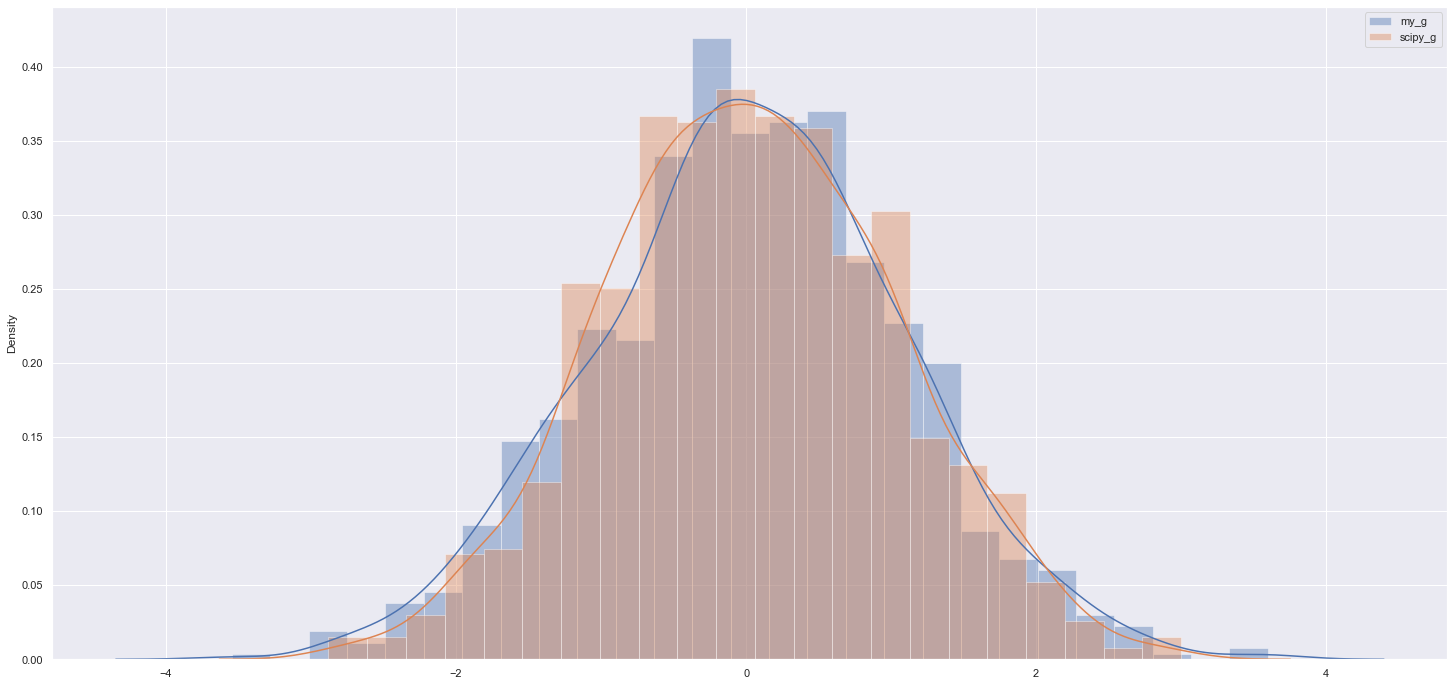

In [4]:
# init our new dist
my_g = my_gaussian(name='my_g')
# init the built in scipy method
scipy_g = stats.norm(loc=0, scale=1)

# define number of samples
n = 1000
# get both distribution pdf numbers
my_g_samples = my_g.rvs(size=n)
scipy_g_samples = scipy_g.rvs(size=n)

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_g_samples, label='my_g', ax=ax)
sns.distplot(scipy_g_samples, label='scipy_g', ax=ax)
ax.legend();

So on the face of it it's worked. We generated `1,000` random numbers from a custom distribution __and all we had to do was specify a pdf.__ This is worth re-iterating: all we've done is give SciPy a custom pdf and it has managed to sample numbers from that distribution.

## If that's the case then what was all that chat about cdfs and inverse sampling?

It does seem quite remarkable, __however that's because underneath the hood SciPy is doing a lot for us.__ To see this, we can compare the time it takes to sample from our distribution vs the built in version.

In [5]:
%timeit my_g.rvs(size=n)

11.2 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit scipy_g.rvs(size=n)

126 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So just to be clear, we are almost `75,000x` slower than the built in version and that is just for `1,000` samples. Let's start digging into this to understand where this huge speed difference comes from.

## The rvs method

We can first have a look at what goes on when we run the `rvs` method for our custom class:

In [8]:
# scipy/stats/_distn_infrastructure.py
def _rvs(self, *args, size=None, random_state=None):
    # This method must handle size being a tuple, and it must
    # properly broadcast *args and size.  size might be
    # an empty tuple, which means a scalar random variate is to be
    # generated.

    # Use basic inverse cdf algorithm for RV generation as default.
    U = random_state.uniform(size=size)
    Y = self._ppf(U, *args)
    return Y

In [152]:
# define our gaussian look-a-like distribution
class my_gaussian(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)

In [157]:
my_g = my_gaussian(0.8, name='mix_g')
scipy_g = stats.norm()

In [160]:
xs = np.linspace(-4, 4, 10001)

my_pdf = [my_g.pdf(x) for x in xs]
scipy_pdf = [scipy_g.pdf(x) for x in xs]

my_cdf = [my_g.cdf(x) for x in xs]
scipy_cdf = [scipy_g.cdf(x) for x in xs]

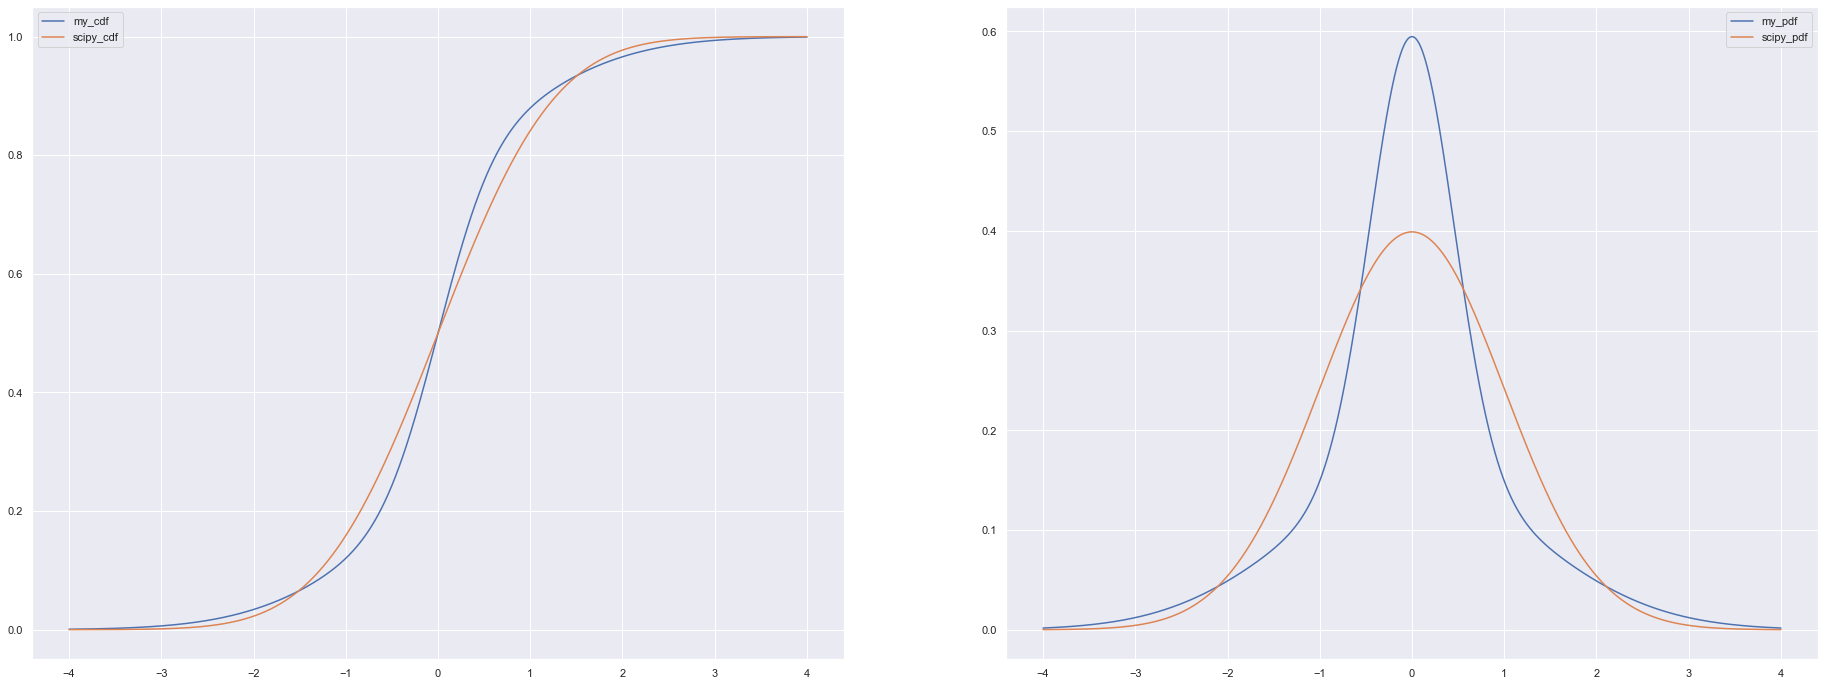

In [161]:
fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

axes[0].plot(xs, my_cdf, label='my_cdf')
axes[0].plot(xs, scipy_cdf, label='scipy_cdf')
axes[0].legend()

axes[1].plot(xs, my_pdf, label='my_pdf')
axes[1].plot(xs, scipy_pdf, label='scipy_pdf')
axes[1].legend();

In [276]:
# define our gaussian look-a-like distribution
class my_gaussian_two(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)

    def _ppf(self, x):
        return 0.5 * (_norm_ppf(x) * (1 - self.e)**0.5 + _norm_ppf(x) * (1 + self.e)**0.5)

In [252]:
def norm_p(x, loc=0, scale=1):
    return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))

In [261]:
from scipy.stats._continuous_distns import _norm_cdf, _norm_ppf

In [253]:
x = 1
mu = 2
sigma = 3

Proof of pdf being true

In [254]:
norm_p(x, loc=mu, scale=sigma)

0.12579440923099772

In [256]:
norm_p((x - mu)/sigma) / sigma

0.12579440923099774

Proof of cdf being true

In [262]:
_norm_cdf((x - mu) / sigma) 

0.36944134018176367

In [263]:
stats.norm.cdf(x, loc=mu, scale=sigma)

0.36944134018176367

Proof of ppf being true

In [272]:
x = 0.1

In [273]:
stats.norm.ppf(x, loc=mu, scale=sigma)

-1.844654696633801

In [275]:
_norm_ppf(x) * sigma + mu

-1.844654696633801

In [271]:
?? scipy_g.dist.ppf

Signature:  scipy_g.dist.ppf(q, *args, **kwds)
Source:   
    def ppf(self, q, *args, **kwds):
        """Percent point function (inverse of `cdf`) at q of the given RV.

        Parameters
        ----------
        q : array_like
            lower tail probability
        arg1, arg2, arg3,... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information)
        loc : array_like, optional
            location parameter (default=0)
        scale : array_like, optional
            scale parameter (default=1)

        Returns
        -------
        x : array_like
            quantile corresponding to the lower tail probability q.

        """
        args, loc, scale = self._parse_args(*args, **kwds)
        q, loc, scale = map(asarray, (q, loc, scale))
        args = tuple(map(asarray, args))
        _a, _b = self._get_support(*args)
        cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
        

In [277]:
my_g_2 = my_gaussian_two(0.8, name='mix_g')
scipy_g = stats.norm()

xs = np.linspace(-4, 4, 10001)

my_pdf_2 = [my_g_2.pdf(x) for x in xs]
scipy_pdf = [scipy_g.pdf(x) for x in xs]

my_cdf_2 = [my_g_2.cdf(x) for x in xs]
scipy_cdf = [scipy_g.cdf(x) for x in xs]

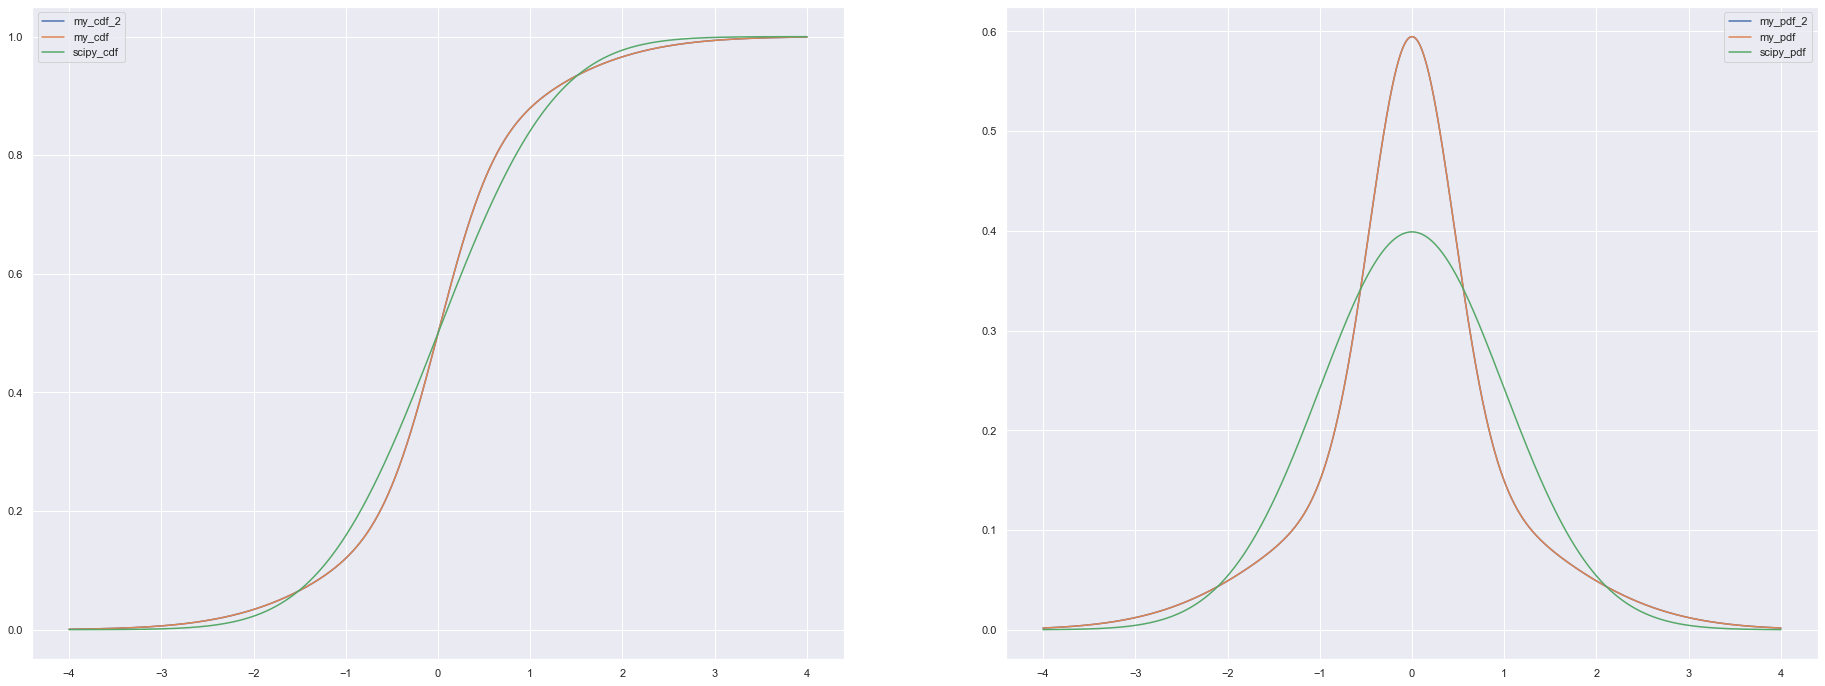

In [278]:
fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

axes[0].plot(xs, my_cdf_2, label='my_cdf_2')
axes[0].plot(xs, my_cdf, label='my_cdf')
axes[0].plot(xs, scipy_cdf, label='scipy_cdf')
axes[0].legend()

axes[1].plot(xs, my_pdf_2, label='my_pdf_2')
axes[1].plot(xs, my_pdf, label='my_pdf')
axes[1].plot(xs, scipy_pdf, label='scipy_pdf')
axes[1].legend();

In [185]:
np.mean(my_g_samples)

nan

In [190]:
?? my_g_2._rvs

Signature:  my_g_2._rvs(*args, size=None, random_state=None)
Docstring: <no docstring>
Source:   
    def _rvs(self, *args, size=None, random_state=None):
        # This method must handle size being a tuple, and it must
        # properly broadcast *args and size.  size might be
        # an empty tuple, which means a scalar random variate is to be
        # generated.

        # Use basic inverse cdf algorithm for RV generation as default.
        U = random_state.uniform(size=size)
        Y = self._ppf(U, *args)
        return Y
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [191]:
uni = np.random.uniform(size=n)

In [217]:
x = uni[5]
0.5 * (_norm_ppf(x * (1 - 0.8)**0.5) + _norm_ppf(x * (1 + 0.8)**0.5))

nan

In [222]:
x * (1 + 0.8)**0.5

1.1645016535924015

In [221]:
_norm_ppf(x * (1 + 0.8)**0.5)

-0.2840991012141975

In [215]:
my_g_2._ppf(uni)[:6]

array([-1.11049638,  0.78241239,  0.68313284,  0.07532408, -0.63209118,
               nan])

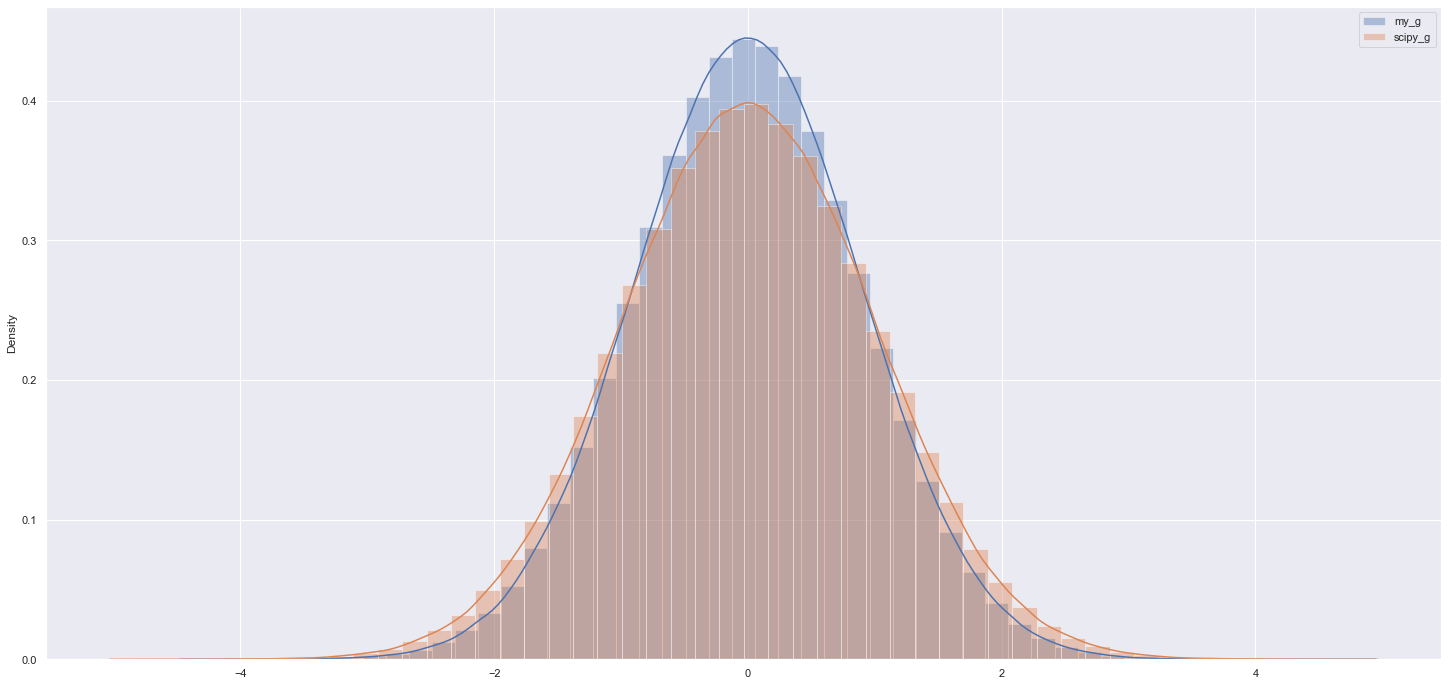

In [282]:
# init our new dist
my_g_2 = my_gaussian_two(0.8, name='mix_g')
# init the built in scipy method
scipy_g = stats.norm(loc=0, scale=1)

# define number of samples
n = 1000000
# get both distribution pdf numbers
my_g_samples = my_g_2.rvs(size=n)
scipy_g_samples = scipy_g.rvs(size=n)

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_g_samples, label='my_g_2', ax=ax)
sns.distplot(scipy_g_samples, label='scipy_g', ax=ax)
ax.legend();

In [283]:
np.var(my_g_samples)

0.8006888896621454

In [284]:
np.var(scipy_g_samples)

1.000681091972323

In [285]:
stats.kurtosis(my_g_samples)

-0.00490696025560311

In [286]:
stats.kurtosis(scipy_g_samples)

0.0035013581215324052

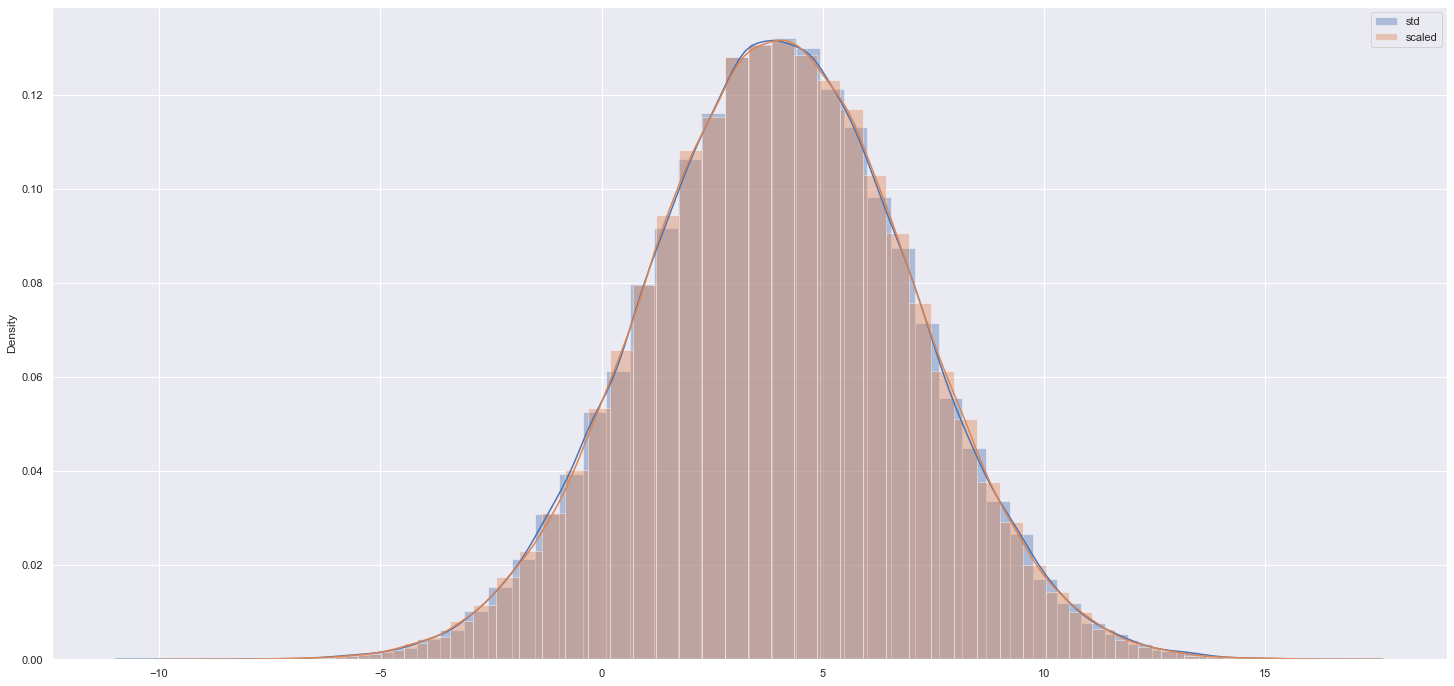

In [229]:
n = 100000
mu = 4
sigma = 3


std_norm = stats.norm(loc=0, scale=1)
scaled_norm = stats.norm(loc=mu, scale=sigma)

std_samples = std_norm.rvs(size=n)
scaled_samples = scaled_norm.rvs(size=n)

std_samples = [x * sigma + mu for x in std_samples]

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(std_samples, label='std', ax=ax)
sns.distplot(scaled_samples, label='scaled', ax=ax)
ax.legend();

In [230]:
sigma = 1
e = 0.5

low_g = stats.norm(scale=sigma*(1 - e)**0.5)
high_g = stats.norm(scale=sigma*(1 + e)**0.5)
mid_g = stats.norm(scale=sigma)

In [231]:
low_g.ppf(0.1)

-0.9061938024368232

In [232]:
high_g.ppf(0.1)

-1.569573707324611

In [233]:
mid_g.ppf(0.1)

-1.2815515655446004

In [235]:
np.mean([low_g.ppf(0.1), high_g.ppf(0.1)])

-1.2378837548807171

In [243]:
?? my_g_2._ppf

Signature:  my_g_2._ppf(x)
Docstring: <no docstring>
Source:   
    def _ppf(self, x):
        return 0.5 * (_norm_ppf(x * (1 - self.e)**0.5) + _norm_ppf(x * (1 + self.e)**0.5))
File:      /var/folders/vr/c2cyr6ys3kj_1wr_jt3543b40000gn/T/ipykernel_2599/1750142853.py
Type:      method


In [16]:
?? scipy_g.dist._rvs

Signature:  scipy_g.dist._rvs(size=None, random_state=None)
Docstring: <no docstring>
Source:   
    def _rvs(self, size=None, random_state=None):
        return random_state.standard_normal(size)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py
Type:      method


In [20]:
?? scipy_g.dist._random_state

Type:        RandomState
String form: RandomState(MT19937)
File:        ~/dev/opcoes/.venv/lib/python3.9/site-packages/numpy/random/mtrand.cpython-39-darwin.so
Docstring:  
RandomState(seed=None)

Container for the slow Mersenne Twister pseudo-random number generator.
Consider using a different BitGenerator with the Generator container
instead.

`RandomState` and `Generator` expose a number of methods for generating
random numbers drawn from a variety of probability distributions. In
addition to the distribution-specific arguments, each method takes a
keyword argument `size` that defaults to ``None``. If `size` is ``None``,
then a single value is generated and returned. If `size` is an integer,
then a 1-D array filled with generated values is returned. If `size` is a
tuple, then an array with that shape is filled and returned.

**Compatibility Guarantee**

A fixed bit generator using a fixed seed and a fixed series of calls to
'RandomState' methods using the same parameters will always

In [35]:
?? my_g.rvs

Signature:  my_g.rvs(*args, **kwds)
Source:   
    def rvs(self, *args, **kwds):
        """Random variates of given type.

        Parameters
        ----------
        arg1, arg2, arg3,... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            Location parameter (default=0).
        scale : array_like, optional
            Scale parameter (default=1).
        size : int or tuple of ints, optional
            Defining number of random variates (default is 1).
        random_state : {None, int, `numpy.random.Generator`,
                        `numpy.random.RandomState`}, optional

            If `seed` is None (or `np.random`), the `numpy.random.RandomState`
            singleton is used.
            If `seed` is an int, a new ``RandomState`` instance is used,
            seeded with `seed`.
            If `seed` is already a ``Generator`` or ``RandomSt

In [18]:
?? scipy_g.dist.rvs

Signature:  scipy_g.dist.rvs(*args, **kwds)
Source:   
    def rvs(self, *args, **kwds):
        """Random variates of given type.

        Parameters
        ----------
        arg1, arg2, arg3,... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            Location parameter (default=0).
        scale : array_like, optional
            Scale parameter (default=1).
        size : int or tuple of ints, optional
            Defining number of random variates (default is 1).
        random_state : {None, int, `numpy.random.Generator`,
                        `numpy.random.RandomState`}, optional

            If `seed` is None (or `np.random`), the `numpy.random.RandomState`
            singleton is used.
            If `seed` is an int, a new ``RandomState`` instance is used,
            seeded with `seed`.
            If `seed` is already a ``Generator`` or ``

In [21]:
?? scipy_g.dist._rvs

Signature:  scipy_g.dist._rvs(size=None, random_state=None)
Docstring: <no docstring>
Source:   
    def _rvs(self, size=None, random_state=None):
        return random_state.standard_normal(size)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py
Type:      method


In [22]:
?? my_g._rvs

Signature:  my_g._rvs(*args, size=None, random_state=None)
Docstring: <no docstring>
Source:   
    def _rvs(self, *args, size=None, random_state=None):
        # This method must handle size being a tuple, and it must
        # properly broadcast *args and size.  size might be
        # an empty tuple, which means a scalar random variate is to be
        # generated.

        # Use basic inverse cdf algorithm for RV generation as default.
        U = random_state.uniform(size=size)
        Y = self._ppf(U, *args)
        return Y
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [23]:
?? my_g._ppf

Signature:  my_g._ppf(q, *args)
Docstring: <no docstring>
Source:   
    def _ppf(self, q, *args):
        return self._ppfvec(q, *args)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [24]:
?? my_g._ppf_single

Signature:  my_g._ppf_single(q, *args)
Docstring: <no docstring>
Source:   
    def _ppf_single(self, q, *args):
        factor = 10.
        left, right = self._get_support(*args)

        if np.isinf(left):
            left = min(-factor, right)
            while self._ppf_to_solve(left, q, *args) > 0.:
                left, right = left * factor, left
            # left is now such that cdf(left) <= q
            # if right has changed, then cdf(right) > q

        if np.isinf(right):
            right = max(factor, left)
            while self._ppf_to_solve(right, q, *args) < 0.:
                left, right = right, right * factor
            # right is now such that cdf(right) >= q

        return optimize.brentq(self._ppf_to_solve,
                               left, right, args=(q,)+args, xtol=self.xtol)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [25]:
?? my_g._ppf_to_solve

Signature:  my_g._ppf_to_solve(x, q, *args)
Docstring: <no docstring>
Source:   
    def _ppf_to_solve(self, x, q, *args):
        return self.cdf(*(x, )+args)-q
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [128]:
from scipy.stats._continuous_distns import _norm_ppf
from scipy.stats._continuous_distns import _norm_pdf

In [29]:
# define our gaussian look-a-like distribution
class my_gaussian(stats.rv_continuous):
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)
    def _ppf(self, x):
        return _norm_ppf(x)

In [30]:
# init our new dist
my_g = my_gaussian(name='my_g')
# define number of samples
n = 1000

In [31]:
# get both distribution pdf numbers
my_g_samples = my_g.rvs(size=n)

In [32]:
%timeit  my_g.rvs(size=n)

156 µs ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
%timeit scipy_g.rvs(size=n)

287 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [68]:
# ?? stats.rv_continuous

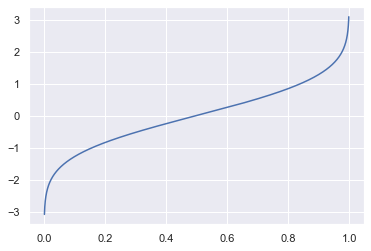

In [87]:
plt.plot(np.linspace(0.001, 0.999, 10001), [stats.norm.ppf(x) for x in np.linspace(0.001, 0.999, 10001)])

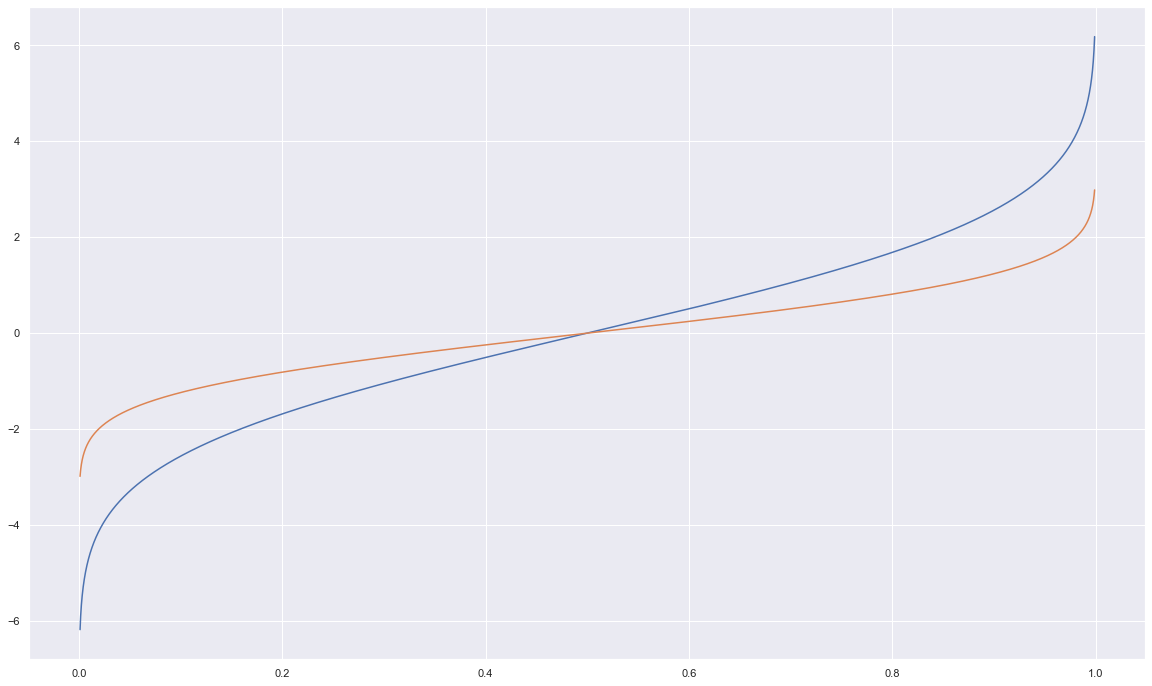

In [94]:
e = 0.5
xs = np.linspace(0.001, 0.999, 10001)
std = [stats.norm.ppf(x, scale=2) for x in xs]
# mix = [stats.norm.ppf(x)*2 for x in xs]
mix = [0.5 * stats.norm.ppf(x, scale=(1 - e)**0.5) + 0.5 * stats.norm.ppf(x, scale=(1 + e)**0.5) for x in xs]

fig, ax = plt.subplots(ncols=1, figsize=(20,12))

ax.plot(xs, std)
ax.plot(xs, mix)

In [133]:
# define our gaussian look-a-like distribution
class my_mix_gauss(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    def _norm_p(x, mu=0, sigma=1):
        return np.exp(-x**2 / (2. * sigma**2)) / (sigma * np.sqrt(2.0 * np.pi))
    
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        
        low = _norm_pdf(x) * (1 - self.e)**0.5
        high = _norm_pdf(x) * (1 + self.e)**0.5
        return 0.5 * (low + high)
    
    # def _ppf(self, x):
    #    return 0.5 * _norm_ppf(x) * (1 - self.e)**0.5 + 0.5 * _norm_ppf(x) * (1 + self.e)**0.5

In [135]:
# init the built in scipy method
scipy_g = stats.norm(loc=0, scale=1)
# init our new dist
my_mix_g = my_mix_gauss(0.5, name='my_g')

# define number of samples
n = 10
# get both distribution pdf numbers
my_mix_g_samples = my_mix_g.rvs(size=n)
scipy_g_samples = scipy_g.rvs(size=n)

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_mix_g_samples, label='my_g', ax=ax)
sns.distplot(scipy_g_samples, label='scipy_g', ax=ax)
ax.legend();

OverflowError: (34, 'Result too large')

In [109]:
?? my_g.ppf

Signature:  my_g.ppf(q, *args, **kwds)
Source:   
    def ppf(self, q, *args, **kwds):
        """Percent point function (inverse of `cdf`) at q of the given RV.

        Parameters
        ----------
        q : array_like
            lower tail probability
        arg1, arg2, arg3,... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information)
        loc : array_like, optional
            location parameter (default=0)
        scale : array_like, optional
            scale parameter (default=1)

        Returns
        -------
        x : array_like
            quantile corresponding to the lower tail probability q.

        """
        args, loc, scale = self._parse_args(*args, **kwds)
        q, loc, scale = map(asarray, (q, loc, scale))
        args = tuple(map(asarray, args))
        _a, _b = self._get_support(*args)
        cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
        cond1 = 